<a href="https://colab.research.google.com/github/Elisakova/github_welcom/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F__%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%98%D1%81%D0%B0%D0%BA%D0%BE%D0%B2%D0%B0_%D0%95_%D0%A1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание временных рядов

## Введение. Постановка целей и задач.

Солнце оказывает наибольшее влияние на климат на Земле. Впервые было замечено, что солнечные пятна влияют на Землю, когда ученые поняли, что повышенная активность солнечных пятен создает повышенные помехи для магнитных приборов на поверхности земли. 
Цень  прогноз числа пятен 




### Импорт Датафрейма, библиотек, написание функций.

В этом блоке мы импортируем все, что нам нужно для работы: библиотеки, отдельные функции, сам датасет.

In [34]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 

In [31]:
data = sm.datasets.sunspots.load_pandas()

In [40]:
df=data.data
df.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


Знакомство с данными.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         309 non-null    float64
 1   SUNACTIVITY  309 non-null    float64
dtypes: float64(2)
memory usage: 5.0 KB


In [5]:
df.dtypes

YEAR           float64
SUNACTIVITY    float64
dtype: object

In [6]:
df.shape

(309, 2)

In [7]:
df.isnull().sum()

YEAR           0
SUNACTIVITY    0
dtype: int64

In [8]:
df.describe(include='all')

,YEAR,SUNACTIVITY
count,309.000000,309.000000
mean,1854.000000,49.752104
std,89.344838,40.452595
min,1700.000000,0.000000
25%,1777.000000,16.000000
50%,1854.000000,40.000000
75%,1931.000000,69.800000
max,2008.000000,190.200000


Выводы по разделу: Датасет  содержит 309  наблюдений, две переменные , тип переменной -float. Переменная YEAR - год наблюдения,  переменная SUNACTIVITY -  количество  пятен на солнце. В данных  нет пропущених значений. 



## Предобработка данных

Проиндексируем переменную "Year"

In [64]:
df.index=pd.Index(pd.date_range("1700", end="2009", freq="A-DEC"))

df.head()


,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0


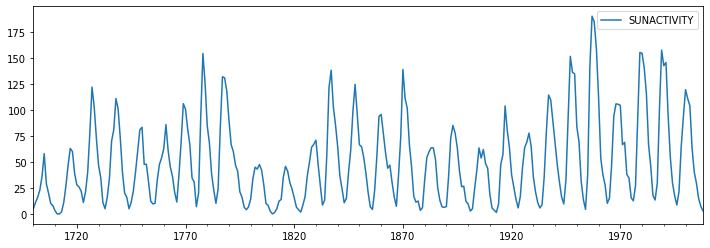

In [60]:
#df.plot(figsize=(12,4))

### Фильтрация данных

Обычно фильтрацию данных делают позже - когда нужно непосредственно работать с данными. В нашем случае это неудобно: у нас условие, по которому мы выбираем какой-либо параметр 

С другой стороны, столбцов в задании может быть многовато. Поэтому на этом этапе нам нужно избавиться от всех ненужных столбцов. Чтобы понять, какие столбцы нужны - лучше всего вспомнить суть задачи. 


По итогу у нас должен остаться небольшой **датасет**.

### Обработка пропусков

В этом блоке мы должны понять - почему у нас есть пропуски. Главный вопрос - какова их природа? 

После того, как мы это поймем, мы можем принять решение относительно заполнения пропусков.

Главный момент: **в рамках этого задания мы не удаляем ничего, связанного с пропусками!**

Главная причина - характер работы с данными: мы работаем в этой задаче с временным промежутком, и нам важно, чтобы не было отсутствующих дат. К примеру, ситуация, когда у нас есть пропуск продолжительностью от 1 до 3 дней в середине временного промежутка, попросту неприемлима.

После обработки пропусков нам обязательно нужно проверить - всё ли в порядке. Выведите данные и проверьте заполненность. Зафиксируйте то, что пропусков больше нет.

### Вывод по этапу.


## EDA или разведочный анализ данных.

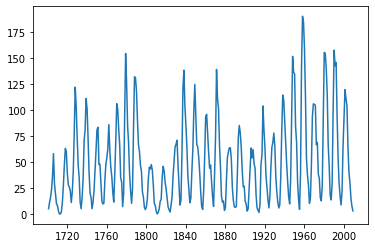

In [65]:
fig, ax=plt.subplots()
ax.plot(df['SUNACTIVITY'])


В данном блоке наша задача - познакомиться "поближе" с данными, которыми мы располагаем.

Что лучше всего сделать:    
- Сделать столбец с датами индексом;
- Вывести статистику по нужным столбцам;
- Построить графическое отображение столбцов;
- Попробовать определить - есть ли столбцы, которые мы можем отфильтровать (к примеру, самые ранние записи, где информации могло не быть и где были NaN). **- такого может и не быть**


Проделав действия выше, мы выполним минимум, необходимый для дальнейшей работы. 

Помимо этой информации, здесь же нужно всесторонне познакомиться с рассматриваемыми данными в контексте процесса/явления.

Хорошо здесь описать всё, что влияет на метрику, и что может нам помочь определить следующее: можем ли мы достоверно предсказать рост или падение метрики на основании одной переменной? Или здесь нужны методы посложнее, с большим числом входных данных и зависимостей?

Отвечайте на вопросы честно! 

Как только мы поняли, что описанной информации достаточно - можно перейти к следующему пункту.

## Построение моделей, анализ результатов.

Данный блок содержит в себе решение поставленной задачи.

В прошлых блоках мы убедились в целостности данных, их логичности, а также в том, что мы понимаем, с чем мы имеем дело. 

На этом этапе у нас должен быть объект типа DataFrame или Series, где индекс - даты, а в значениях находится нужная информация. То есть временной ряд.

В данном блоке у нас должно быть от трёх до четырех подглав:    
- Разделение датасета на тренировочную и тестовую (валидационную) выборки, проверка на статичность, построение графиков автокорреляции и частичной автокорреляции, разбивка на сезонность и тренд.
- Применение 1 способа прогнозирования;
- Применение 2 способа прогнозирования;
- (Применение 3 способа прогнозирования); **По желанию**

Первый пункт - разделение датасета - универсален, данные из него не нужно обновлять или заного рассчитывать.

Остальные три пункта содержат примерно одинаковый алгоритм действий:    
1. Описываем вкратце модель.
2. Создаем модель.
3. Обучаем модель.
4. Создаем прогноз.
5. Сравниваем прогноз и предсказание. 
6. Рассчитываем качество полученной модели и прогноза.
7. Делаем выводы по прогнозу.


Какие модели у нас есть:
- В рамках курса мы рассмотрели модель ARIMA, её улучшенную версию SARIMA. Обязательно попробуйте использовать эту модель;
- Модель экспаненционного сглаживающего среднего;
- Модель Хольта-Винтерса.

Последние 2 модели мы не изучали, поэтому можно попробовать использовать составные от модели ARIMA, которые мы рассматривали в лекции - AR, MA.

После получения прогноза отобразите графики **прогноз vs факт**, чтобы визуально можно было посмотреть на то, как точно построен прогноз. 

Как понять, подходит ли модель. Попробуйте использовать следующие методы рассчета ошибки:
- MAPE или средняя абсолютная ошибка в процентах.
- RMSE - квадратный корень из среднеквадратичной ошибки.
- MSE - среднеквадратичный корень (связан  с RMSE).

В конце - сравните полученные метрики с ошибками и выберите ту модель, которая точнее всего создает прогноз.

Ещё один важный момент - горизонт прогнозирования и сравнение прогноза с данными. Горизонт планирования нужно сделать небольшим - примерно 10-15 наблюдений (то есть 10-15 дней). И в ошибку нужно сравнивать с таким же числом наблюдений за тот же период по реальным данным!

Также отмечу, что прогноз, скорее всего, будет не самым точным, а возможно, он совсем покажет что-то непонятное.

## Выводы

В данном блоке опишите общие выводы по работе: что было сделано, что было получено. Помните, отрицательный результат - тоже результат. Поэтому указывайте информацию честно и беспристратно. 